In [6]:
import os
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

MODELS_DIR = os.path.abspath("C:/Projects/tensorflow/models")
MODEL_FILE_PATH = os.path.join(MODELS_DIR, "mnist_model.h5")
FULL_MODEL_FILE_PATH = os.path.join(MODELS_DIR, "full_mnist_model")
LOGS_DIR = os.path.abspath("C:/Projects/tensorflow/logs")
MODEL_LOGS_DIR = os.path.join(LOGS_DIR, "mnist_logs")

Preprocessing

In [13]:
def get_dataset(num_classes: int) -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    (x_train, y_train), (x_val_, y_val_) = cifar10.load_data()
    x_train = x_train.astype(np.float32)
    x_val_ = x_val_.astype(np.float32)
    x_val, x_test, y_val, y_test = train_test_split(x_val_, y_val_, test_size=0.66)
    x_test = x_test.astype(np.float32)
    
    # normalize
    x_train = x_train/255.0
    x_val = x_val/255.0
    x_test = x_test/255.0

    # Data Augmentation
    augment_size = 5_000
    image_gen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.05,
        width_shift_range=0.08,
        height_shift_range=0.08
    )
    image_gen.fit(x_train, augment=True)
    rndm_idxs = np.random.randint(low=x_train.shape[0],high=None, size=augment_size)
    x_augmented = x_train[rndm_idxs].copy()
    y_augmented = y_train[rndm_idxs].copy()
    x_augmented = image_gen.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]
    x_train = np.concatenate((x_train, x_augmented))
    y_train = np.concatenate((y_train, y_augmented))
    
    y_train = to_categorical(y_train, num_classes=num_classes, dtype=np.float32)
    y_val = to_categorical(y_val, num_classes=num_classes, dtype=np.float32)
    y_test = to_categorical(y_test, num_classes=num_classes, dtype=np.float32)
    print (f"x shape: {x_train.shape}   y shape: {y_train.shape}")
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)


Get DATA

In [14]:
num_classes = 10
img_shape = (32, 32, 3)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_dataset(num_classes=num_classes)

x shape: (55000, 32, 32, 3)   y shape: (55000, 10)


In [8]:
def build_model(img_shape : tuple[int,int,int], num_classes: int) -> Model:
    img_input = Input(img_shape)
    x = Conv2D(filters=16, kernel_size=3, padding = "same")(img_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=16, kernel_size=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=3)(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=32, kernel_size=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
     
    x = Flatten()(x)
    x = Dense(units=128)(x)
    x = Activation("relu")(x)
    x = Dense(units=num_classes)(x)
    y_pred = Activation("softmax")(x)
    
    model = Model(
        inputs=[img_input],
        outputs=[y_pred]
    )
    return model

Train the Model

In [9]:
model = build_model(img_shape=img_shape,num_classes=num_classes)

model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

tb_callback = TensorBoard(
    log_dir=MODEL_LOGS_DIR, histogram_freq=1, write_graph=True
)

history = model.fit (x=x_train, 
           y=y_train, 
           epochs=10, 
           batch_size=128, 
           verbose=1, 
           validation_data=(x_val, y_val),
           callbacks=[tb_callback])


x shape: (55000, 32, 32, 3)   y shape: (55000, 10)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 16)        2320      
                                                                 
 activation_13 (Activation)  (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
        

Plot Accuracy

207/207 [==============================] - 1s 5ms/step - loss: 0.8467 - accuracy: 0.7103
Score: [0.8466905355453491, 0.710303008556366]


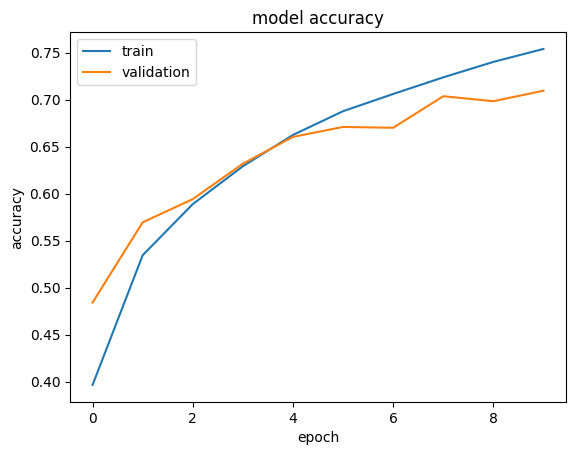

In [15]:
scores = model.evaluate(x=x_test, y=y_test)
print(f"Score: {scores}")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Download Model/Weights

In [ ]:
#weights
model.save_weights(filepath=MODEL_FILE_PATH)
model.save(filepath=FULL_MODEL_FILE_PATH)

Load Model/Weights

In [ ]:
model.load_weights(filepath=MODEL_FILE_PATH)
model = load_model(filepath=FULL_MODEL_FILE_PATH)